In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

!pip install imageio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
import os
import shutil
import copy
import torch

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


import cv2

In [ ]:
class Agent:
    def __init__(self, num_input, num_output):
        self.num_input = num_input 
        self.num_output = num_output
        self.num_genes = num_input * num_output + num_output
        self.weights = None
        self.bias = None

    def set_genes(self, gene):
        weight_idxs = self.num_input * self.num_output
        bias_idxs = self.num_input * self.num_output + self.num_output
        w = gene[0 : weight_idxs].reshape(self.num_output, self.num_input)   
        b = gene[weight_idxs: bias_idxs].reshape(self.num_output,)
        self.weights = torch.from_numpy(w)
        self.bias = torch.from_numpy(b)

    def forward(self, x):
        x = torch.from_numpy(x).unsqueeze(0)
        return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
        if self.forward(x) >= 0:
            return 1
        else:
            return 0

##Visualise agent

In [ ]:
def get_frames(env, agent=None):

    tot_reward = 0.0
    obs = env.reset()
    done = False
    i = 0
    frames = []
    all_obs = []
    frames.append(np.ascontiguousarray(env.render(mode='rgb_array'), dtype=np.uint8))
    all_obs.append(obs)
    cv2.putText(frames[i],f"Step: {i}", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)
    while not done:
        i += 1
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        frames.append(np.ascontiguousarray(env.render(mode='rgb_array'), dtype=np.uint8))
        cv2.putText(frames[i],f"Step: {i}", (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)
        tot_reward = tot_reward + reward
        all_obs.append(obs)
    return frames, all_obs


import imageio
def save_gif(frames, filename='gif1'):
    print("Saving GIF file")
    with imageio.get_writer(filename+'.gif', mode="I") as writer:
      for idx, frame in enumerate(frames):
          writer.append_data(frame)

## fitness function

In [ ]:
def run_episode(env, agent):
    tot_reward = 0.0
    obs = env.reset()
    done = False
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
    return tot_reward

In [ ]:
def fitness_function(env, agent, gene_pop):
    # Get fitness for each gene
    pop_size = gene_pop.shape[0]
    pop_fitness = np.zeros(pop_size)
    for i, gene in enumerate(gene_pop):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)
    return pop_fitness

In [ ]:
def get_best_gene(gene_pop, fitness):
    i = np.argmax(fitness)
    return gene_pop[i]

## GA

In [ ]:
# get two inidividuals from neighbourhood
def neighbours(population,k):
    """Get two individulals from close neighbourhood.

    Args:
        population (np.array(np.array)): List of all individuals' genotypes.
        k (int): Neighbourhood size.

    Returns:
        (int, int): Two individuals' indicies.
    """
    idx = np.random.randint(0,population.shape[0])
    neighbour_idx = np.random.randint(idx+1, idx + k)%population.shape[0] # pick random neighbour
    return idx,neighbour_idx

#get winner loser
def get_winner_loser(ind_1,ind_2,fitness):
    """Compares individuals by their fitnesses.

    Args:
        ind_1 (int): First individual's index in (np.array)population.
        ind_2 (int): Second individual's index in (np.array)population.
        population (np.array): Fitness values of all individuals.

    Returns:
        (int, int):Indecies of individuals in order: (winner, loser)
    """
    if (fitness[ind_1]>=fitness[ind_2]):
        return ind_1,ind_2
    else:
        return ind_2,ind_1
#crossover function
def make_love(W,L,prob):
    """Copies each gene from winner(W) to loser(L) with some probability(prob).

    Args:
        W (np.array): Stronger individual's genotype.
        L (np.array): Loser individual's genotype.
        prob (float, optional): Crossover probability. Defaults to .5.

    Returns:
        np.array: Offspring's genotype.
    """
    C = np.copy(W)
    for i in range(W.shape[0]):
        C[i] = np.random.choice([W[i],L[i]],p=[prob,1-prob])
    return C
def mutation_function(patient, mean, std):
    C = np.copy(patient)
    C = C + np.random.normal(mean, std,C.shape)
    # constraint
    C[C > 4] = 4
    C[C < -4] = -4

    return C

In [ ]:
def GA(env, agent, pop_size, mutation_mean, mutation_std, crossover_probability, deme_size, generations_n, gene_pop=None):
  # Create our gene population
  if gene_pop == None:
      gene_pop = np.random.normal(mutation_mean, mutation_std, (pop_size, agent.num_genes))
  # Get init fitness of the population
  best_fits = np.zeros((generations_n+1))
  fitness = fitness_function(env, agent, gene_pop)
  best_fits[0] = fitness.max()
  successful_n=0
  # Main loop
  for gen in range(generations_n):
      #selection
      ind_1, ind_2 = neighbours(gene_pop,deme_size)
      W,L=get_winner_loser(ind_1, ind_2,fitness)

      #crossover
      gene_pop[L] = make_love(gene_pop[W],gene_pop[L],crossover_probability)

      #create mutant **ominous laugh**
      gene_pop[L] = mutation_function(gene_pop[L],mean=mutation_mean, std=mutation_std)

      # Get fitness of the population
      fitness = fitness_function(env, agent, gene_pop)
      best_fits[gen+1] = fitness.max()
  return best_fits, gene_pop

## experiments

In [ ]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

In [ ]:
np.rad2deg(0.05)

2.8647889756541165

position: -0.02794, velocity: -0.04971, angle: 1.926, angular velocity: 2.045


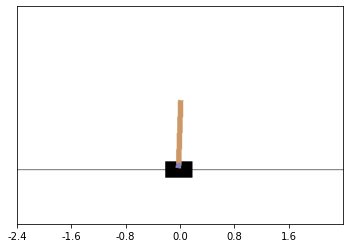

In [ ]:
obs = env.reset()
fig = plt.imshow(env.render(mode="rgb_array"))
fig.axes.get_yaxis().set_visible(False)
ticks = [f"{a:.1f}" for a in np.concatenate((np.array([0]),np.linspace(-2.4,0,4,endpoint=True),np.linspace(0,2.4,4,endpoint=True)[1:]))]
fig.axes.get_xaxis().set_ticklabels(ticks)
print(f"position: {obs[0]:.4}, velocity: {obs[1]:.4}, angle: {np.rad2deg(obs[2]):.4}, angular velocity: {np.rad2deg(obs[3]):.4}")

In [ ]:
num_obs, num_actions = 4,1
agent = Agent(num_obs, num_actions)

# Parameters
params = {
  'generations_n' : 300, 
  'pop_size' : 10, 
  'mutation_mean' : 0, 
  'mutation_std' : 0.1,
  'crossover_probability' : 0.7,
  'deme_size' : 4,
  'gene_pop' : None
  }

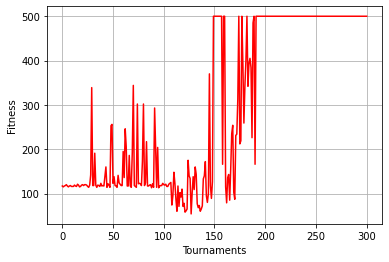

In [ ]:
best_fits, best_pop= GA(env, agent, **params)
plt.plot(range(best_fits.shape[0]),best_fits,color="r",label='Fitness of the best individual')

plt.xlabel('Tournaments')
plt.ylabel('Fitness')
plt.grid()

In [ ]:
agent.set_genes(get_best_gene(best_pop,fitness_function(env,agent,best_pop)))
vis, all_obs = get_frames(env, agent)
save_gif(vis,'ggg')

Saving GIF file


In [ ]:
acc = np.zeros((100,best_pop.shape[0]))
for i in range(100):
  acc[i] = fitness_function(env, agent, best_pop)
acc = (acc == 500).sum(axis=0)/(100)
print(acc)

[0.   1.   0.62 1.   1.   0.   1.   0.   0.   1.  ]


In [ ]:
n_turns=10
champs_fit = []
champs_pop = []
for i in range(n_turns):
  fits, pop = GA(env, agent, **params)
  champs_fit.append(fits)
  champs_pop.append(pop)
champs_fit = np.array(champs_fit)
champs_pop = np.array(champs_pop)

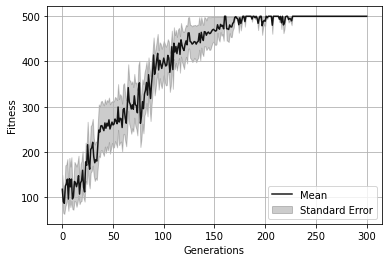

In [ ]:
means = np.mean(champs_fit,axis=0)
ses = np.std(champs_fit,axis=0) / np.sqrt(champs_fit.shape[0])
plt.plot(range(params['generations_n']+1),means,alpha=.9,label='Mean',color='k')
plt.fill_between(range(params['generations_n']+1),means+ses,means-ses,alpha=.2,label='Standard Error'.format(1),color='k')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.legend(loc=4)
plt.grid()

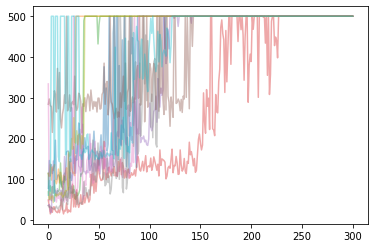

In [ ]:
for c in champs_fit:
  plt.plot(range(params['generations_n']+1),c,alpha=.4)

In [ ]:
champsOfChamps = np.array([get_best_gene(c, fitness_function(env,agent,c)) for c in champs_pop])
acc = np.zeros((100,champsOfChamps.shape[0]))
for i in range(100):
  acc[i] = fitness_function(env, agent, champsOfChamps)
acc = (acc == 500).sum(axis=0)/(100)
print(acc)

[1.   1.   1.   0.96 1.   1.   0.89 1.   1.   0.5 ]


## Visualise champions

Saving GIF file
Saving GIF file
Saving GIF file
Saving GIF file
Saving GIF file
Saving GIF file
Saving GIF file
Saving GIF file
Saving GIF file
Saving GIF file


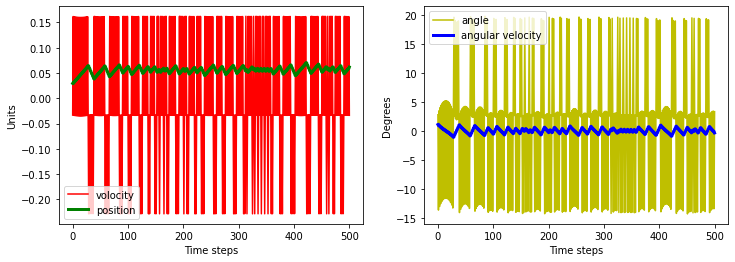

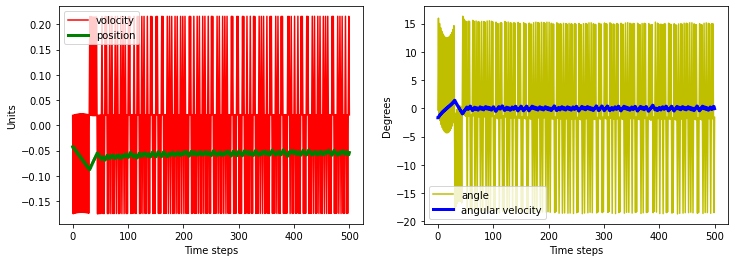

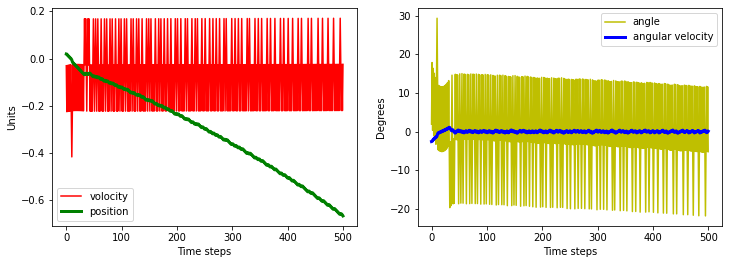

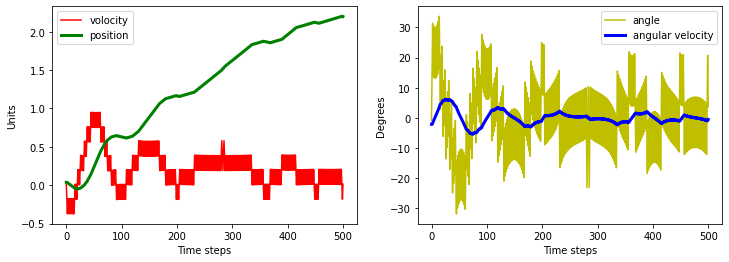

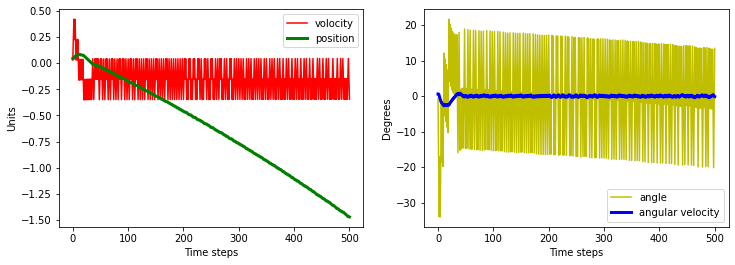

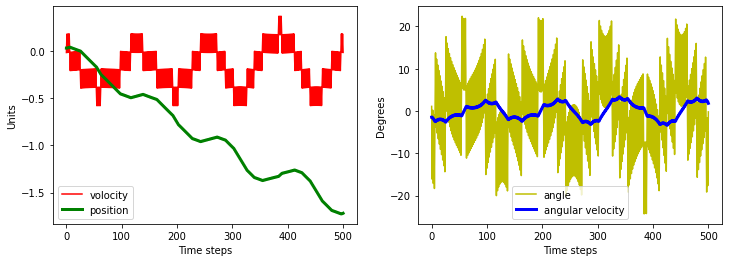

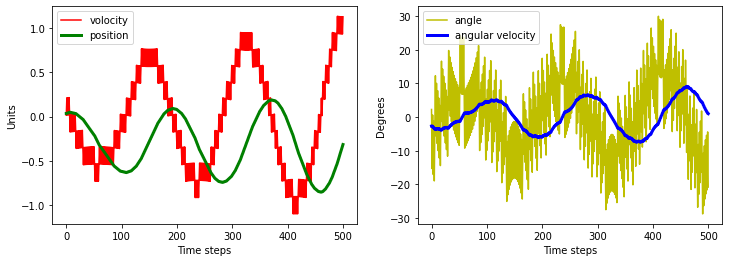

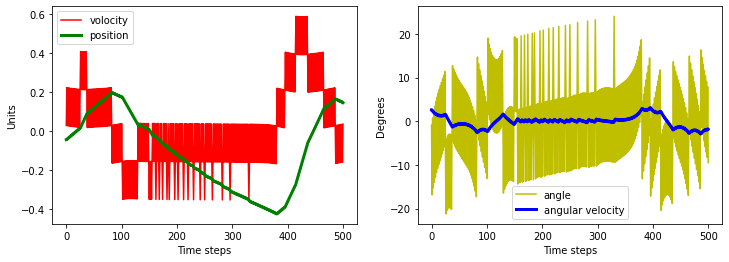

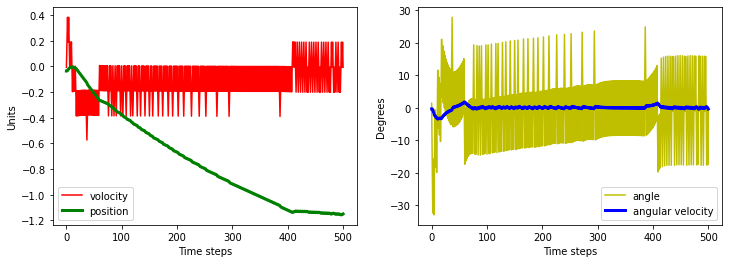

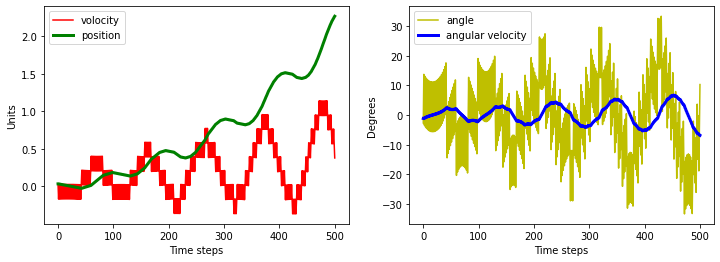

In [69]:
from IPython.core.pylabtools import figsize
# Visualise our agent or save frames to file
for i, c in enumerate(champsOfChamps):
  agent.set_genes(c)
  vis, all_obs = get_frames(env, agent)
  all_obs = np.array(all_obs)
  fig, axs = plt.subplots(1,2,figsize=(12,4))
  axs[0].plot(range(all_obs.shape[0]),all_obs[:,1],color='r',label='volocity')
  axs[0].plot(range(all_obs.shape[0]),all_obs[:,0],color='g',linewidth=3,label='position')
  axs[0].set_xlabel('Time steps')
  axs[0].set_ylabel('Units')
  axs[0].legend()
  axs[1].set_xlabel('Time steps')
  axs[1].set_ylabel('Degrees')
  axs[1].plot(range(all_obs.shape[0]),np.rad2deg(all_obs[:,3]),color='y',label='angle')
  axs[1].plot(range(all_obs.shape[0]),np.rad2deg(all_obs[:,2]),color='b',linewidth=3,label='angular velocity')
  axs[1].legend()
  save_gif(vis,f"champ{i}")


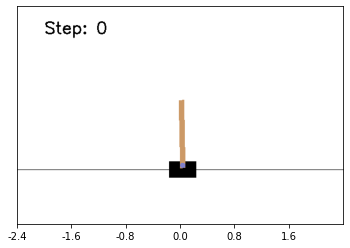

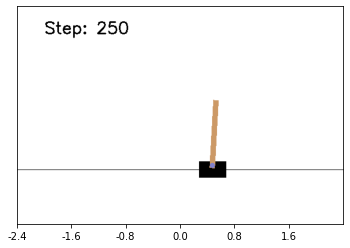

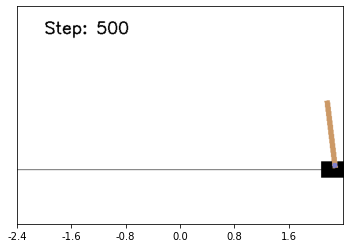

In [70]:
for i in [0, len(vis)//2, -1]:
  plt.figure()
  fig = plt.imshow(vis[i])
  fig.axes.get_yaxis().set_visible(False)
  ticks = [f"{a:.1f}" for a in np.concatenate((np.array([0]),np.linspace(-2.4,0,4,endpoint=True),np.linspace(0,2.4,4,endpoint=True)[1:]))]
  fig.axes.get_xaxis().set_ticklabels(ticks)

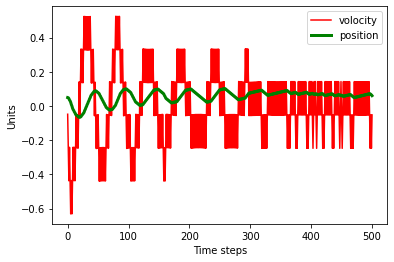

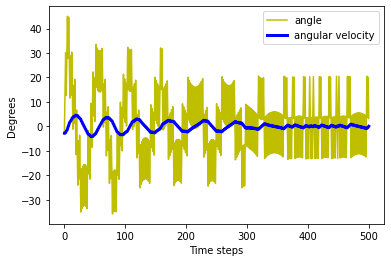